In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import time

from helper_functions import read_field_data, random_sampling, grid_sampling, zone_identifier, construct_interp_funcs, calculate_E_field

In [2]:
# Set up zoning configuration
U2 = -0.5
Ext_pulse = 20
Mesh = 250
MCP = 300
prefix = f'U{-U2}E{Ext_pulse}M{Mesh}M{MCP}'

dc_conf = {
    'gl': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_global.fld'},
    'cy': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cylinder.fld'},
    'c1': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube1.fld'},
    'c2': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube2.fld'},
    'c3': {'file': '..\\Ansys\\Outputs_DC\\Trajectory_sim\\' + prefix + '_cube3.fld'}
        }

In [3]:
# Read data from files based on configuration
dc_conf, grid, voltages = read_field_data(dc_conf)

Reading zone gl
File Readout Time: 7.4874 seconds.
Reading zone cy
File Readout Time: 25.0786 seconds.
Reading zone c1
File Readout Time: 9.3019 seconds.
Reading zone c2
File Readout Time: 11.0006 seconds.
Reading zone c3
File Readout Time: 12.1636 seconds.


In [4]:
# Build interpolating functions
dc_field = calculate_E_field(dc_conf, voltages)

In [5]:
dc_interps, dc_refs = construct_interp_funcs(dc_field, grid, fill_NaNs=True, test_set=True)

Filling NaNs in data for zone gl ...
Time consumed for filling NaNs in x direction: 12.1961 seconds.
Time consumed for filling NaNs in y direction: 11.5656 seconds.
Time consumed for filling NaNs in z direction: 10.6598 seconds.
Filling NaNs in data for zone cy ...
Time consumed for filling NaNs in x direction: 38.9960 seconds.
Time consumed for filling NaNs in y direction: 38.1483 seconds.
Time consumed for filling NaNs in z direction: 36.7938 seconds.
Filling NaNs in data for zone c1 ...
Time consumed for filling NaNs in x direction: 11.5097 seconds.
Time consumed for filling NaNs in y direction: 12.0869 seconds.
Time consumed for filling NaNs in z direction: 11.3381 seconds.
Filling NaNs in data for zone c2 ...
Time consumed for filling NaNs in x direction: 15.7369 seconds.
Time consumed for filling NaNs in y direction: 15.8990 seconds.
Time consumed for filling NaNs in z direction: 16.3979 seconds.
Filling NaNs in data for zone c3 ...
Time consumed for filling NaNs in x direction: 

In [21]:
test_points = grid_sampling((-7.99e-3, 7.99e-3), (0, 0), (0, 0), 5000, 1, 1)

In [56]:
def field_at_point(point, zones, interp, ref=None):
    """
    Evaluates the interpolated field values at a given point.

    Parameters:
        point (array-like): The (x, y, z) coordinates of the point where the field is to be evaluated.
        zones (dict): Configuration dictionary containing zone definitions. Used by 'zone_identifier' to determine which zone the point belongs to.
        interp (dict): Dictionary of interpolation functions for each zone and coordinate component.
                       Structure: interp[zone]['x'], interp[zone]['y'], interp[zone]['z'], where each is a callable interpolation function.
        ref (dict, optional): Dictionary of reference interpolation functions for comparison.
                              Has the same structure as 'interp'. Defaults to None.

    Returns:
        tuple:
            - (value_x, value_y, value_z): The interpolated field values at the point for the x, y, and z components.
            - If 'ref' is provided, returns a tuple of the above and:
                - (ref_x, ref_y, ref_z): The reference interpolated field values at the point for comparison.

    Raises:
        ValueError: If the point does not belong to any zone defined in 'zones'.
    """
    # Determine the zone to which the point belongs
    zone = zone_identifier(point, zones)

    # Evaluate the interpolated field values at the point for each coordinate component
    # Each interpolation function returns an array; we extract the first element [0]
    value_x = interp[zone]['x'](point)[0]  # Field value in x-direction
    value_y = interp[zone]['y'](point)[0]  # Field value in y-direction
    value_z = interp[zone]['z'](point)[0]  # Field value in z-direction

    if ref is None:
        # If no reference functions are provided, return the field values as a tuple
        return (value_x, value_y, value_z)
    else:
        # Evaluate the reference field values at the point for comparison
        ref_x = ref[zone]['x'](point)[0]  # Reference field value in x-direction
        ref_y = ref[zone]['y'](point)[0]  # Reference field value in y-direction
        ref_z = ref[zone]['z'](point)[0]  # Reference field value in z-direction

        # Return both the field values and the reference values as tuples
        return (value_x, value_y, value_z), (ref_x, ref_y, ref_z)

In [103]:
def sample_and_plot_1D(axis, axis_range, step=5000, interp_funcs=dc_interps, ref_funcs=dc_refs):
    """
    Samples points along a specified axis, performs interpolation, and plots the results.

    Parameters:
    - axis (str): The axis to sample ('x', 'y', or 'z').
    - axis_range (tuple): The range of values for the specified axis.
    - step (int): Number of sampling points.
    - interp_funcs: Set of interpolation functions.
    - ref_funcs: Set of reference functions.
    """
    
    # Generate test points based on the specified axis
    if axis == 'x':
        test_points = grid_sampling(axis_range, (0, 0), (0, 0), step, 1, 1)
    elif axis == 'y':
        test_points = grid_sampling((0, 0), axis_range, (0, 0), 1, step, 1)
    elif axis == 'z':
        test_points = grid_sampling((0, 0), (0, 0), axis_range, 1, 1, step)
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'.")

    # Initialize arrays to store interpolation results and errors
    interp_values = np.zeros((len(test_points), 3))
    nearest_values = np.zeros((len(test_points), 3))
    errs = np.zeros((len(test_points), 3))
    relative_errs = np.zeros((len(test_points), 3))

    start_time = time.time()

    # Perform interpolation for each test point
    for i, point in enumerate(test_points):
        try:
            interp_values[i], nearest_values[i] = field_at_point(
                point, dc_conf, interp_funcs, ref_funcs
            )
            errs[i] = interp_values[i] - nearest_values[i]
            relative_errs[i] = np.abs(errs[i]) / np.abs(nearest_values[i])
        except Exception as e:
            print(f"Error interpolating point {point}: {e}")
            interp_values[i] = np.nan
            nearest_values[i] = np.nan
            errs[i] = np.nan
            relative_errs[i] = np.nan

    end_time = time.time()
    print(f'Computation time: {end_time - start_time:.4f} seconds')

    # Define the plotting axis (assuming plotting along 'z')
    z = np.linspace(axis_range[0], axis_range[1], step) * 1000  # Convert to mm

    # Configure plot aesthetics
    plt.rcParams['font.size'] = 15
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    fig.suptitle(f'1D Line {axis_range[0]*1000}mm < {axis} < {axis_range[1]*1000}mm, others = 0')
    ax3s = [0, 0, 0]
    lines = [0, 0, 0]
    line1 = [0, 0, 0]
    line2 = [0, 0, 0]

    for i, component in enumerate(('x', 'y', 'z')):
        # === Subplot 1: Interpolation Comparison ===
        axes[i,0].plot(z, nearest_values[:,i], 'b-', label='Nearest')
        axes[i,0].plot(z, interp_values[:,i], 'r-', label='Interpolated')
        axes[i,0].legend()
        axes[i,0].set_title('Interpolation Comparison')
        axes[i,0].set_xlabel(f'{axis} (mm)')
        axes[i,0].set_ylabel(f'RF equivalent E{component} (V/m)')

        # === Subplot 2: Error Plot ===
        # Plot 'errs' on ax2 in blue
        line1[i], = axes[i,1].plot(z, errs[:,i], 'b-', label='Deviance')
        axes[i,1].set_title('Deviance Plot')
        axes[i,1].set_xlabel(f'{axis} (mm)')
        axes[i,1].set_ylabel(r'$\Delta$ (V/m)', color='b')
        axes[i,1].tick_params(axis='y', labelcolor='b')  # Set y-axis ticks to blue

        # Plot 'relative_errs' on ax3 in red
        ax3s[i] = axes[i,1].twinx()
        line2[i], = ax3s[i].plot(z, relative_errs[:,i], 'r-', label='Relative Deviance')
        ax3s[i].set_ylabel('Relative Error', color='r')
        ax3s[i].tick_params(axis='y', labelcolor='r')  # Set y-axis ticks to red

        # === Combined Legend ===
        # Collect handles and labels from both axes
        lines[i] = [line1[i], line2[i]]
        labels = [line.get_label() for line in lines[i]]
        # Create a unified legend on ax2
        axes[i,1].legend(lines[i], labels, loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
    plt.show()

Computation time: 3.5748 seconds


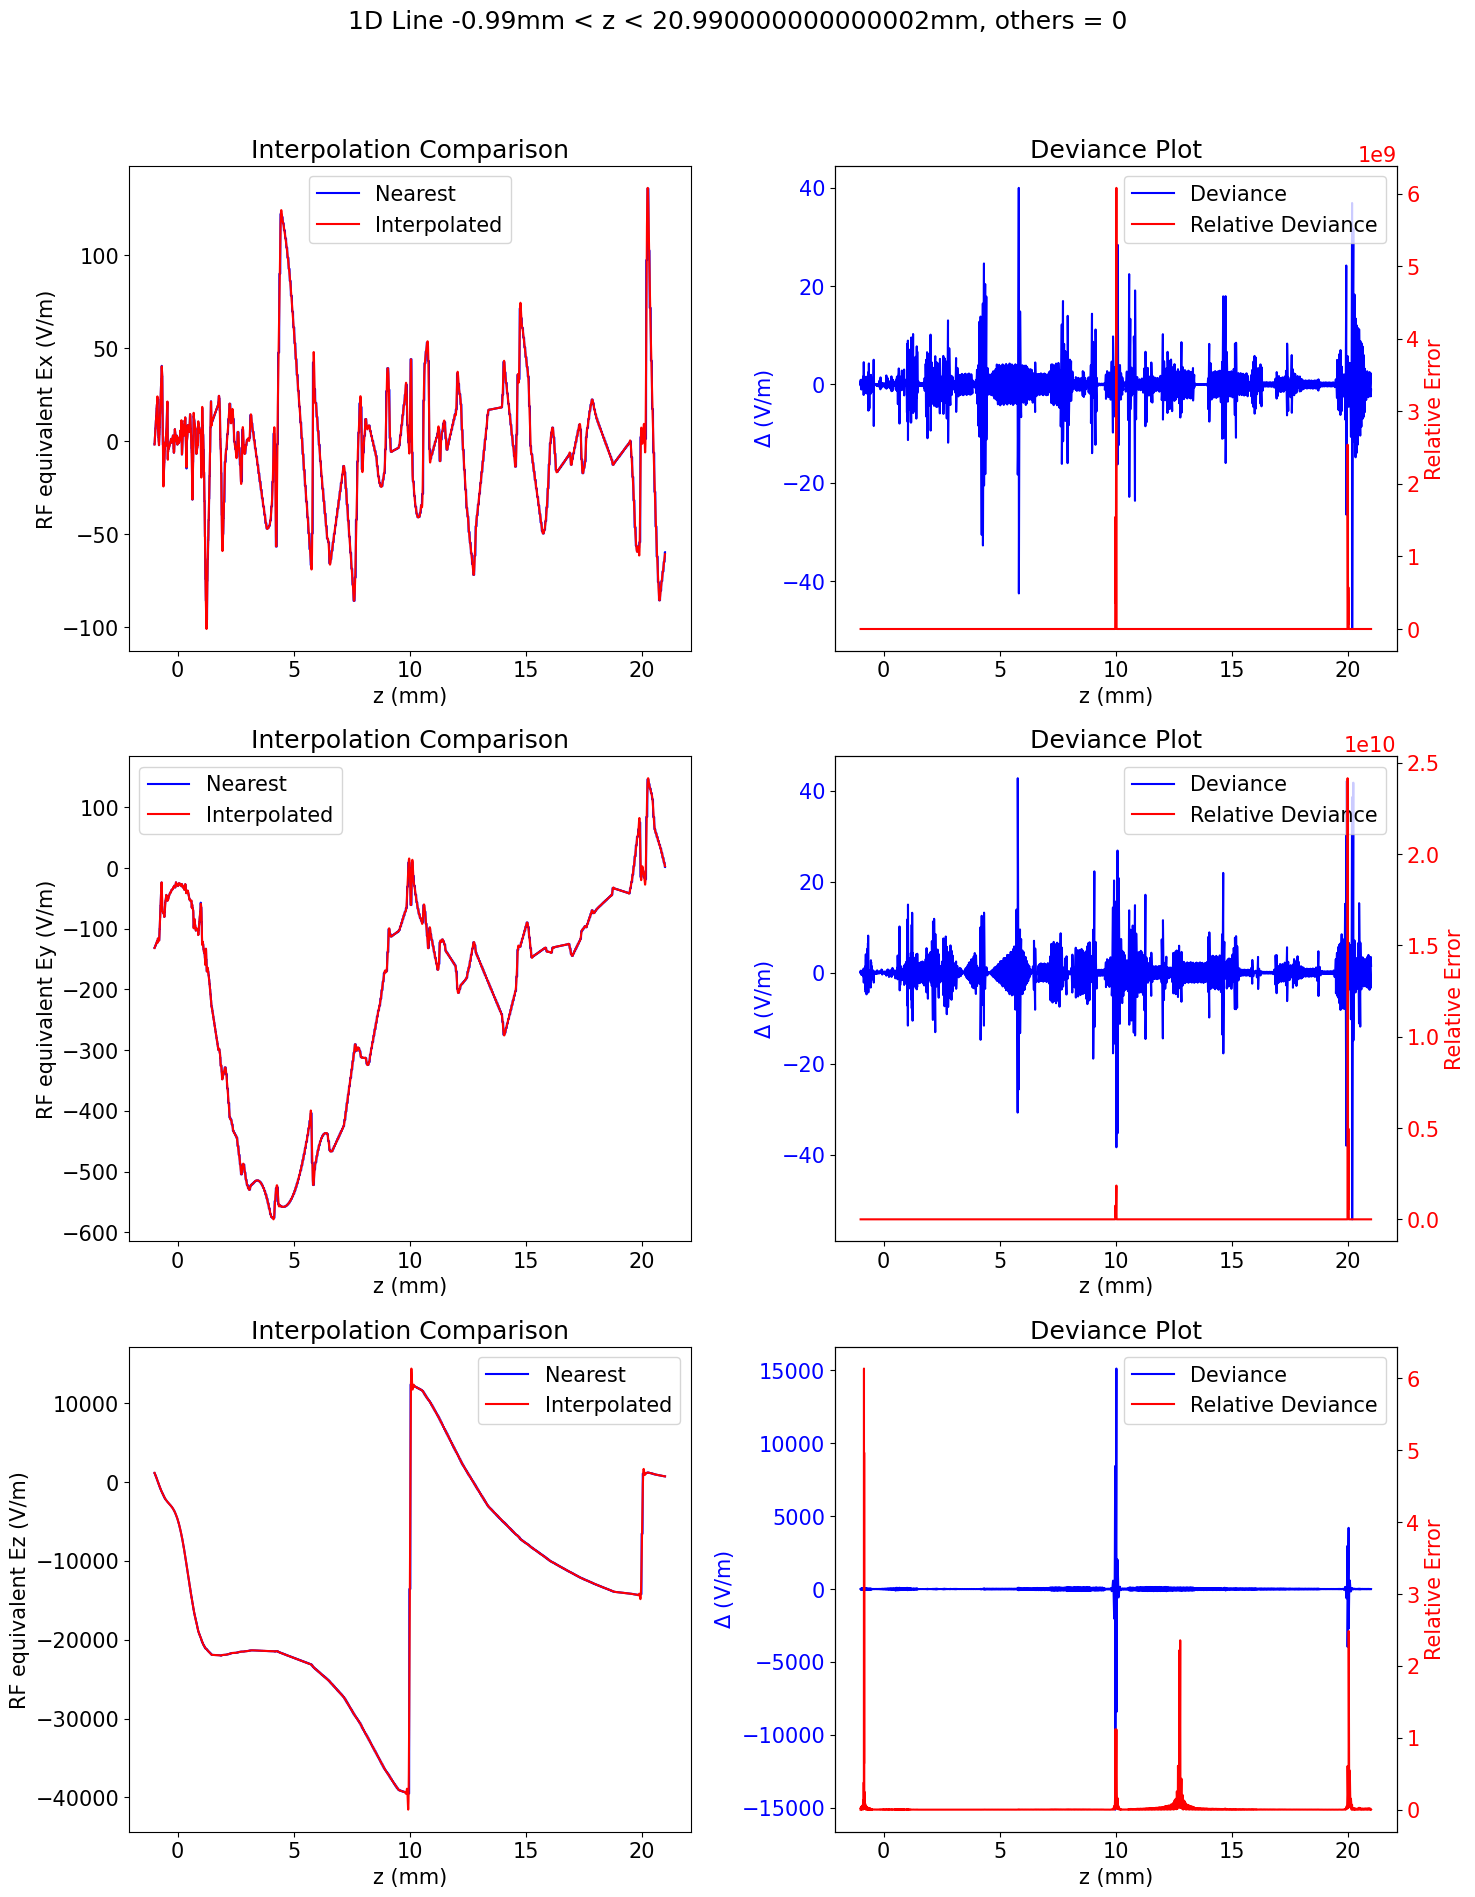

In [107]:
sample_and_plot_1D('z', (-0.99e-3, 20.99e-3))

C:\Users\lluoz\AppData\Local\Temp\ipykernel_18032\1429042131.py:38: RuntimeWarning: divide by zero encountered in divide
  relative_errs[i] = np.abs(errs[i]) / np.abs(nearest_values[i])


Computation time: 3.0230 seconds


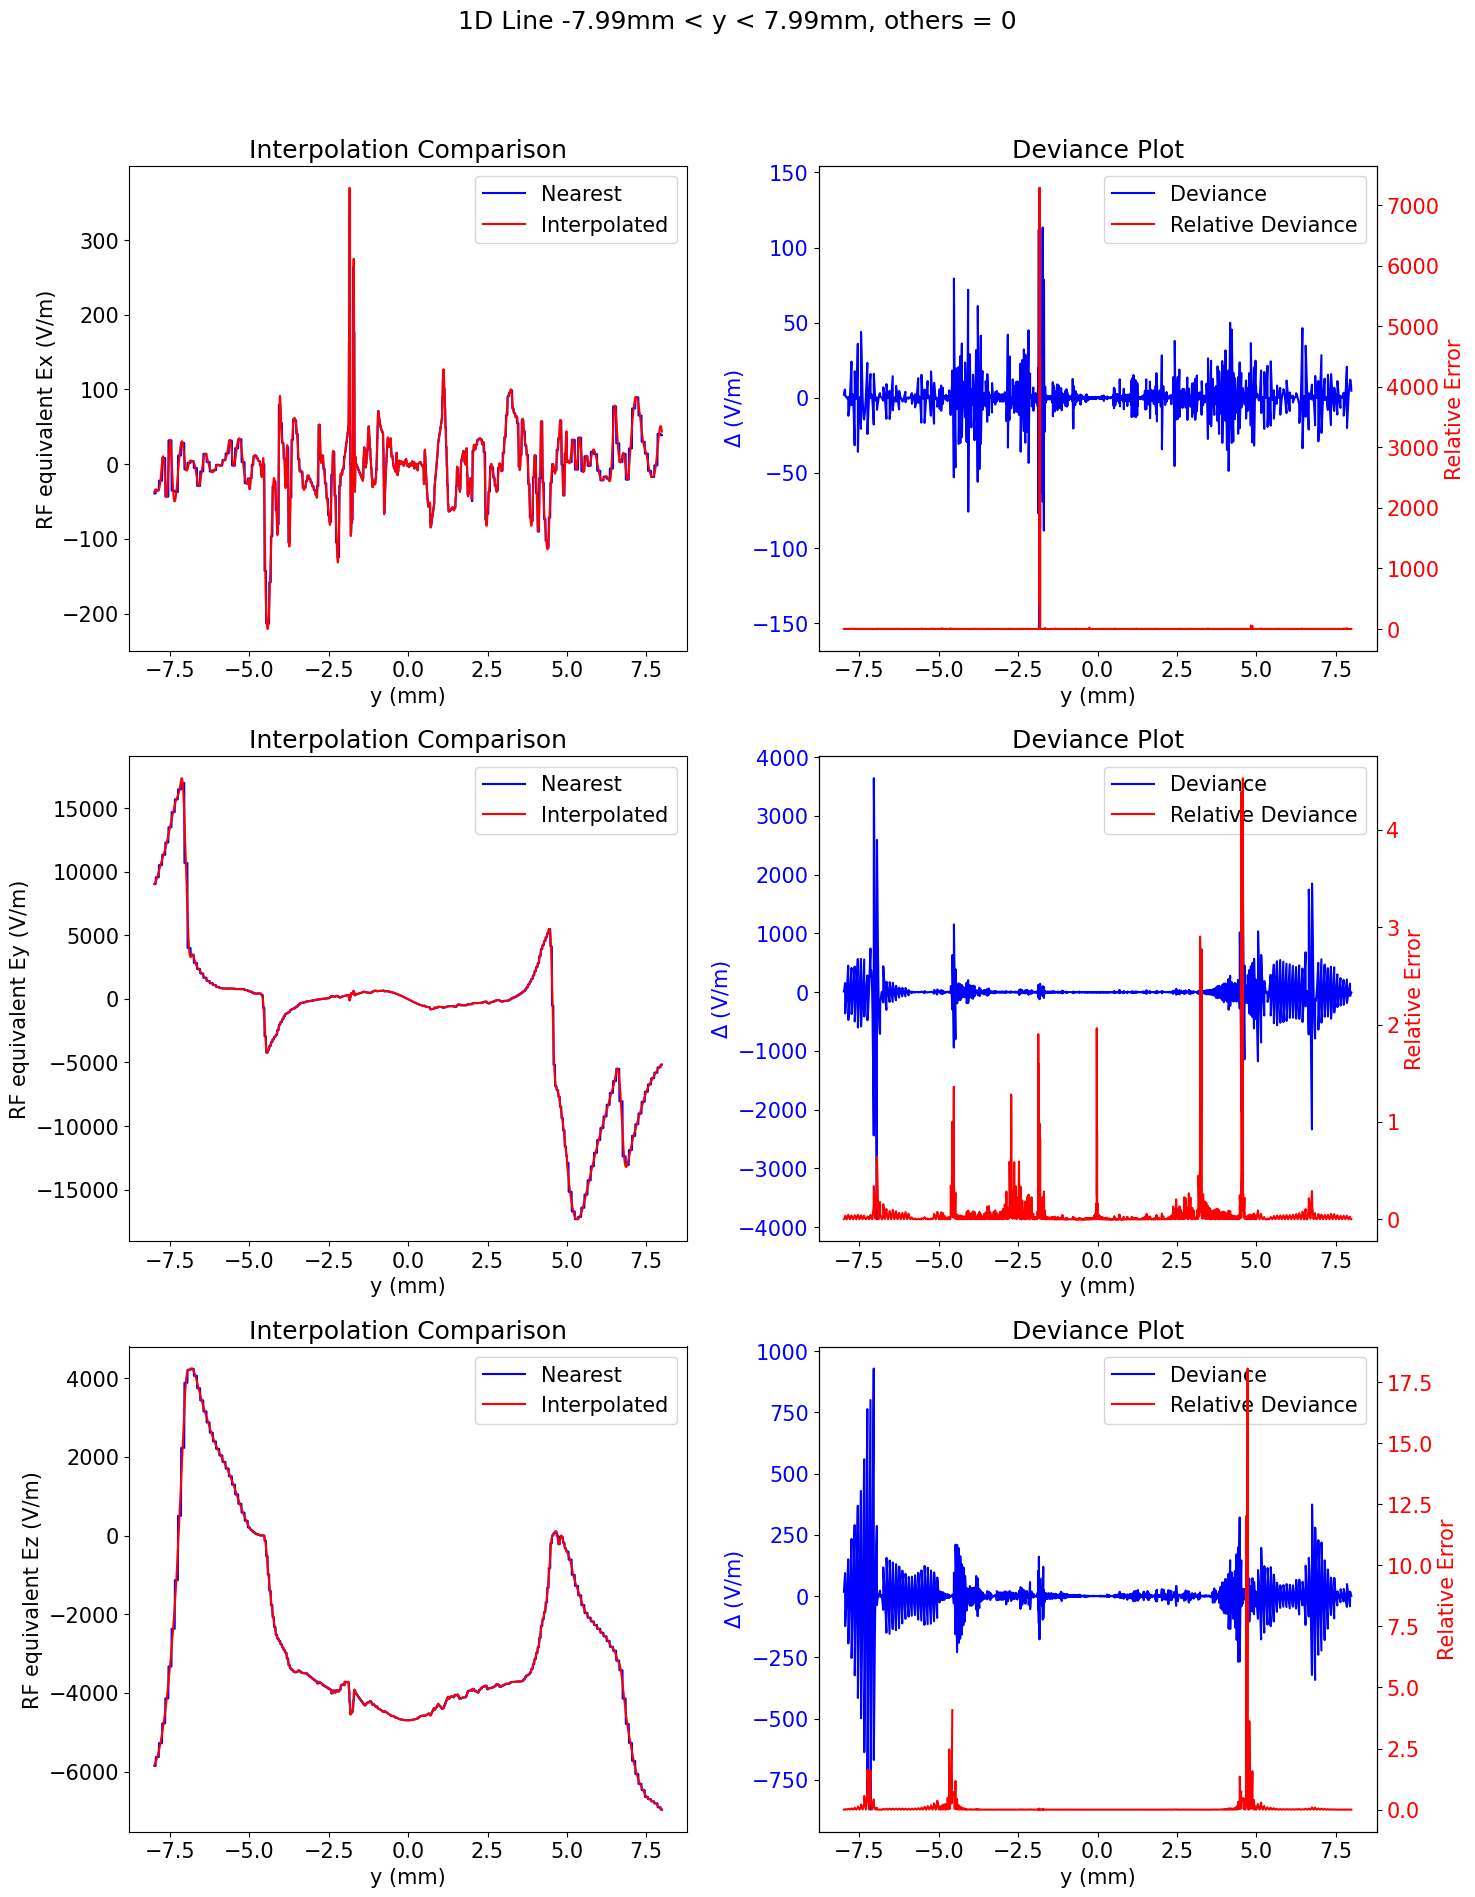

In [108]:
sample_and_plot_1D('y', (-7.99e-3, 7.99e-3))

C:\Users\lluoz\AppData\Local\Temp\ipykernel_18032\1429042131.py:38: RuntimeWarning: divide by zero encountered in divide
  relative_errs[i] = np.abs(errs[i]) / np.abs(nearest_values[i])


Computation time: 3.3526 seconds


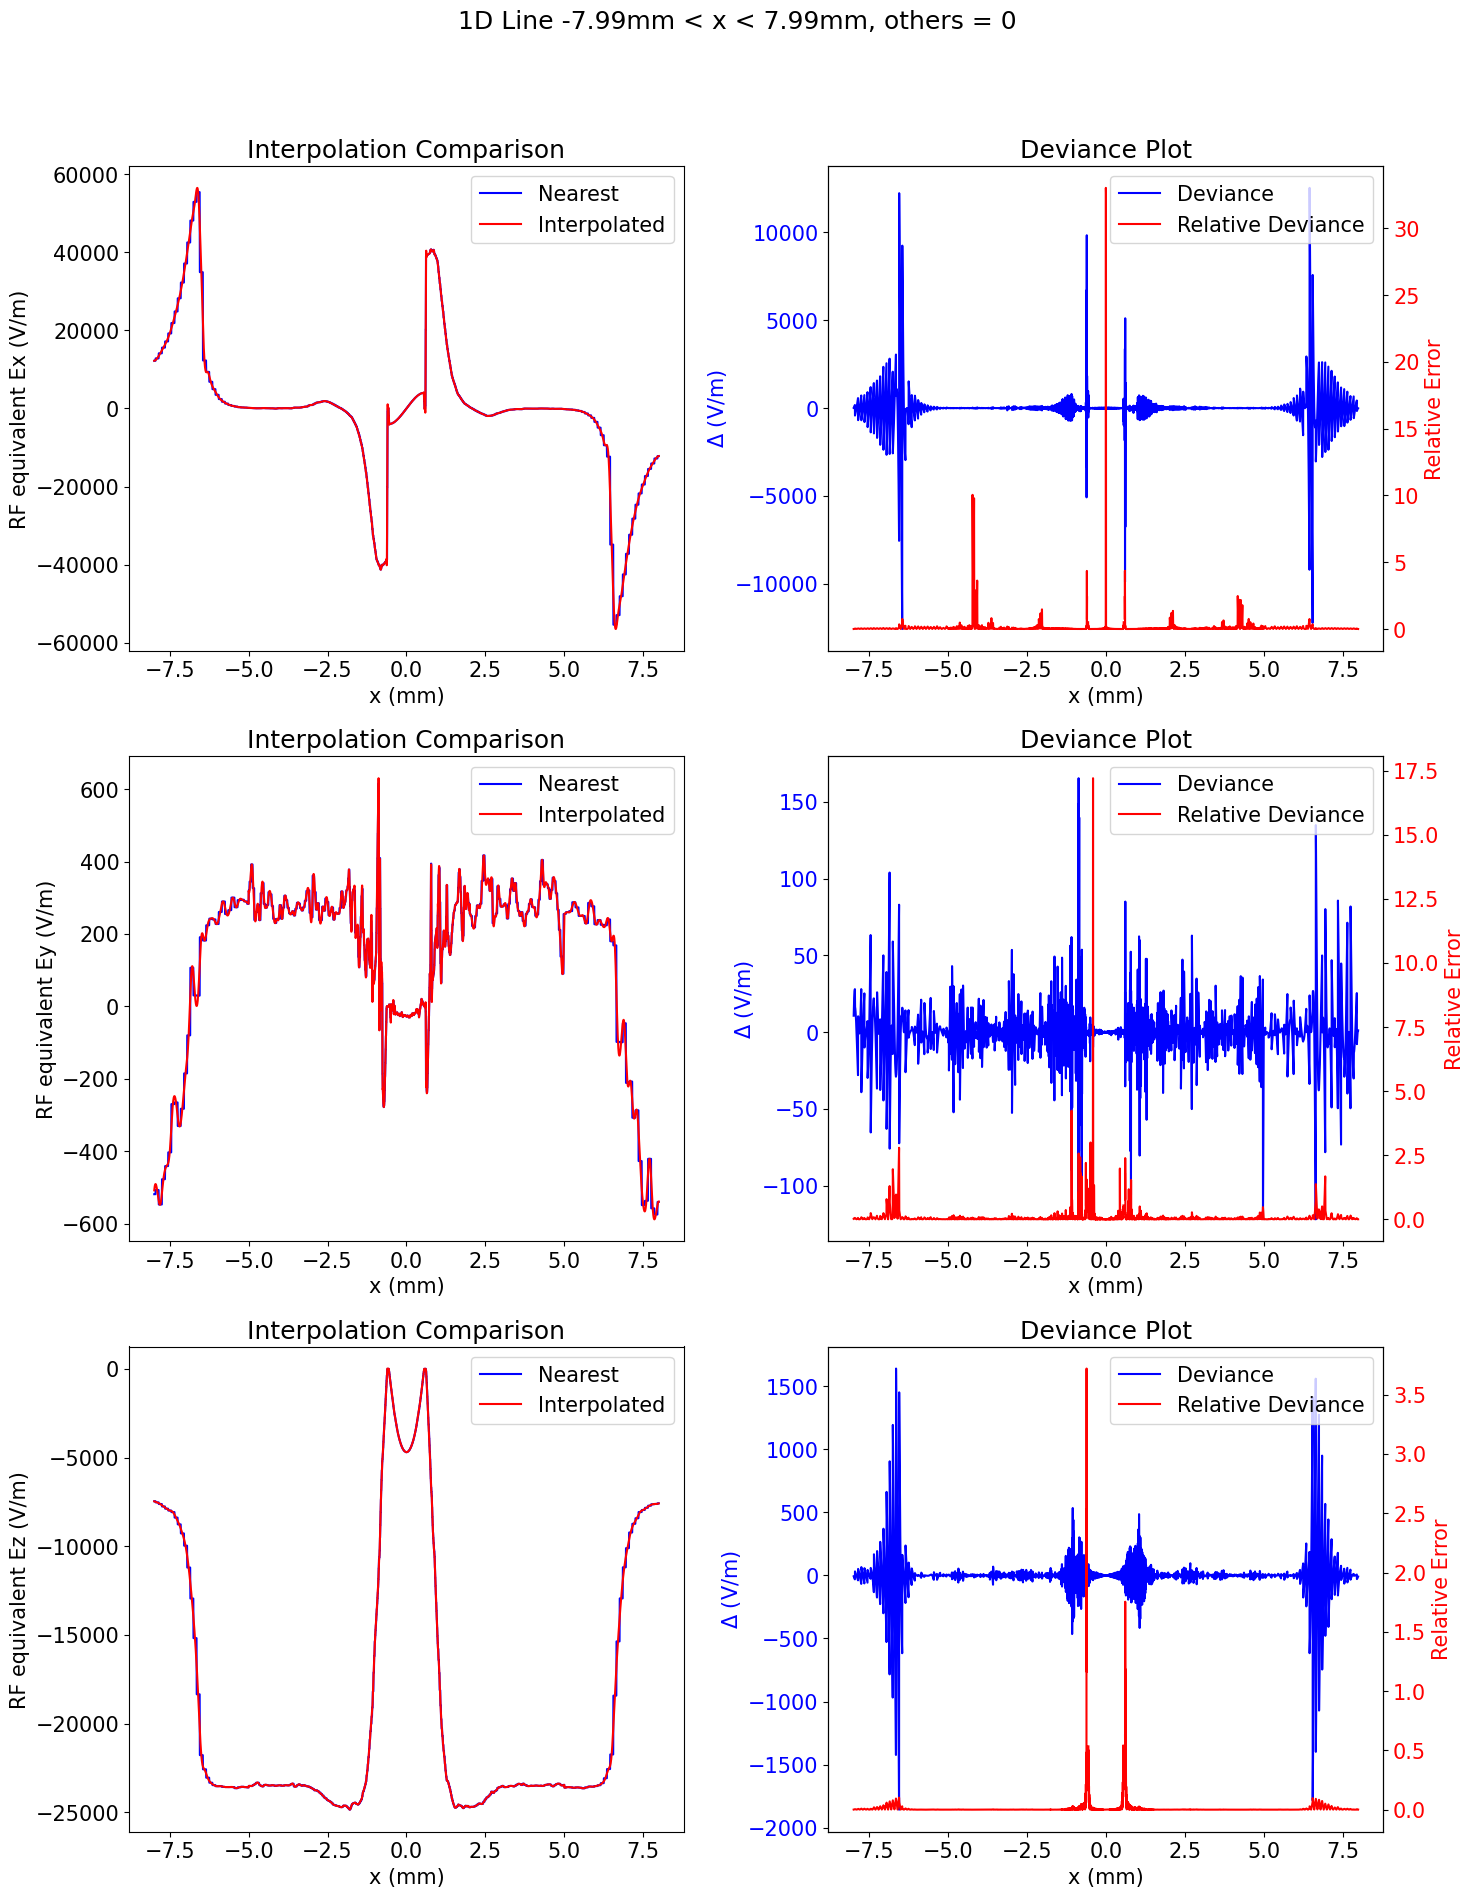

In [109]:
sample_and_plot_1D('x', (-7.99e-3, 7.99e-3))

Computation time: 2.6042 seconds


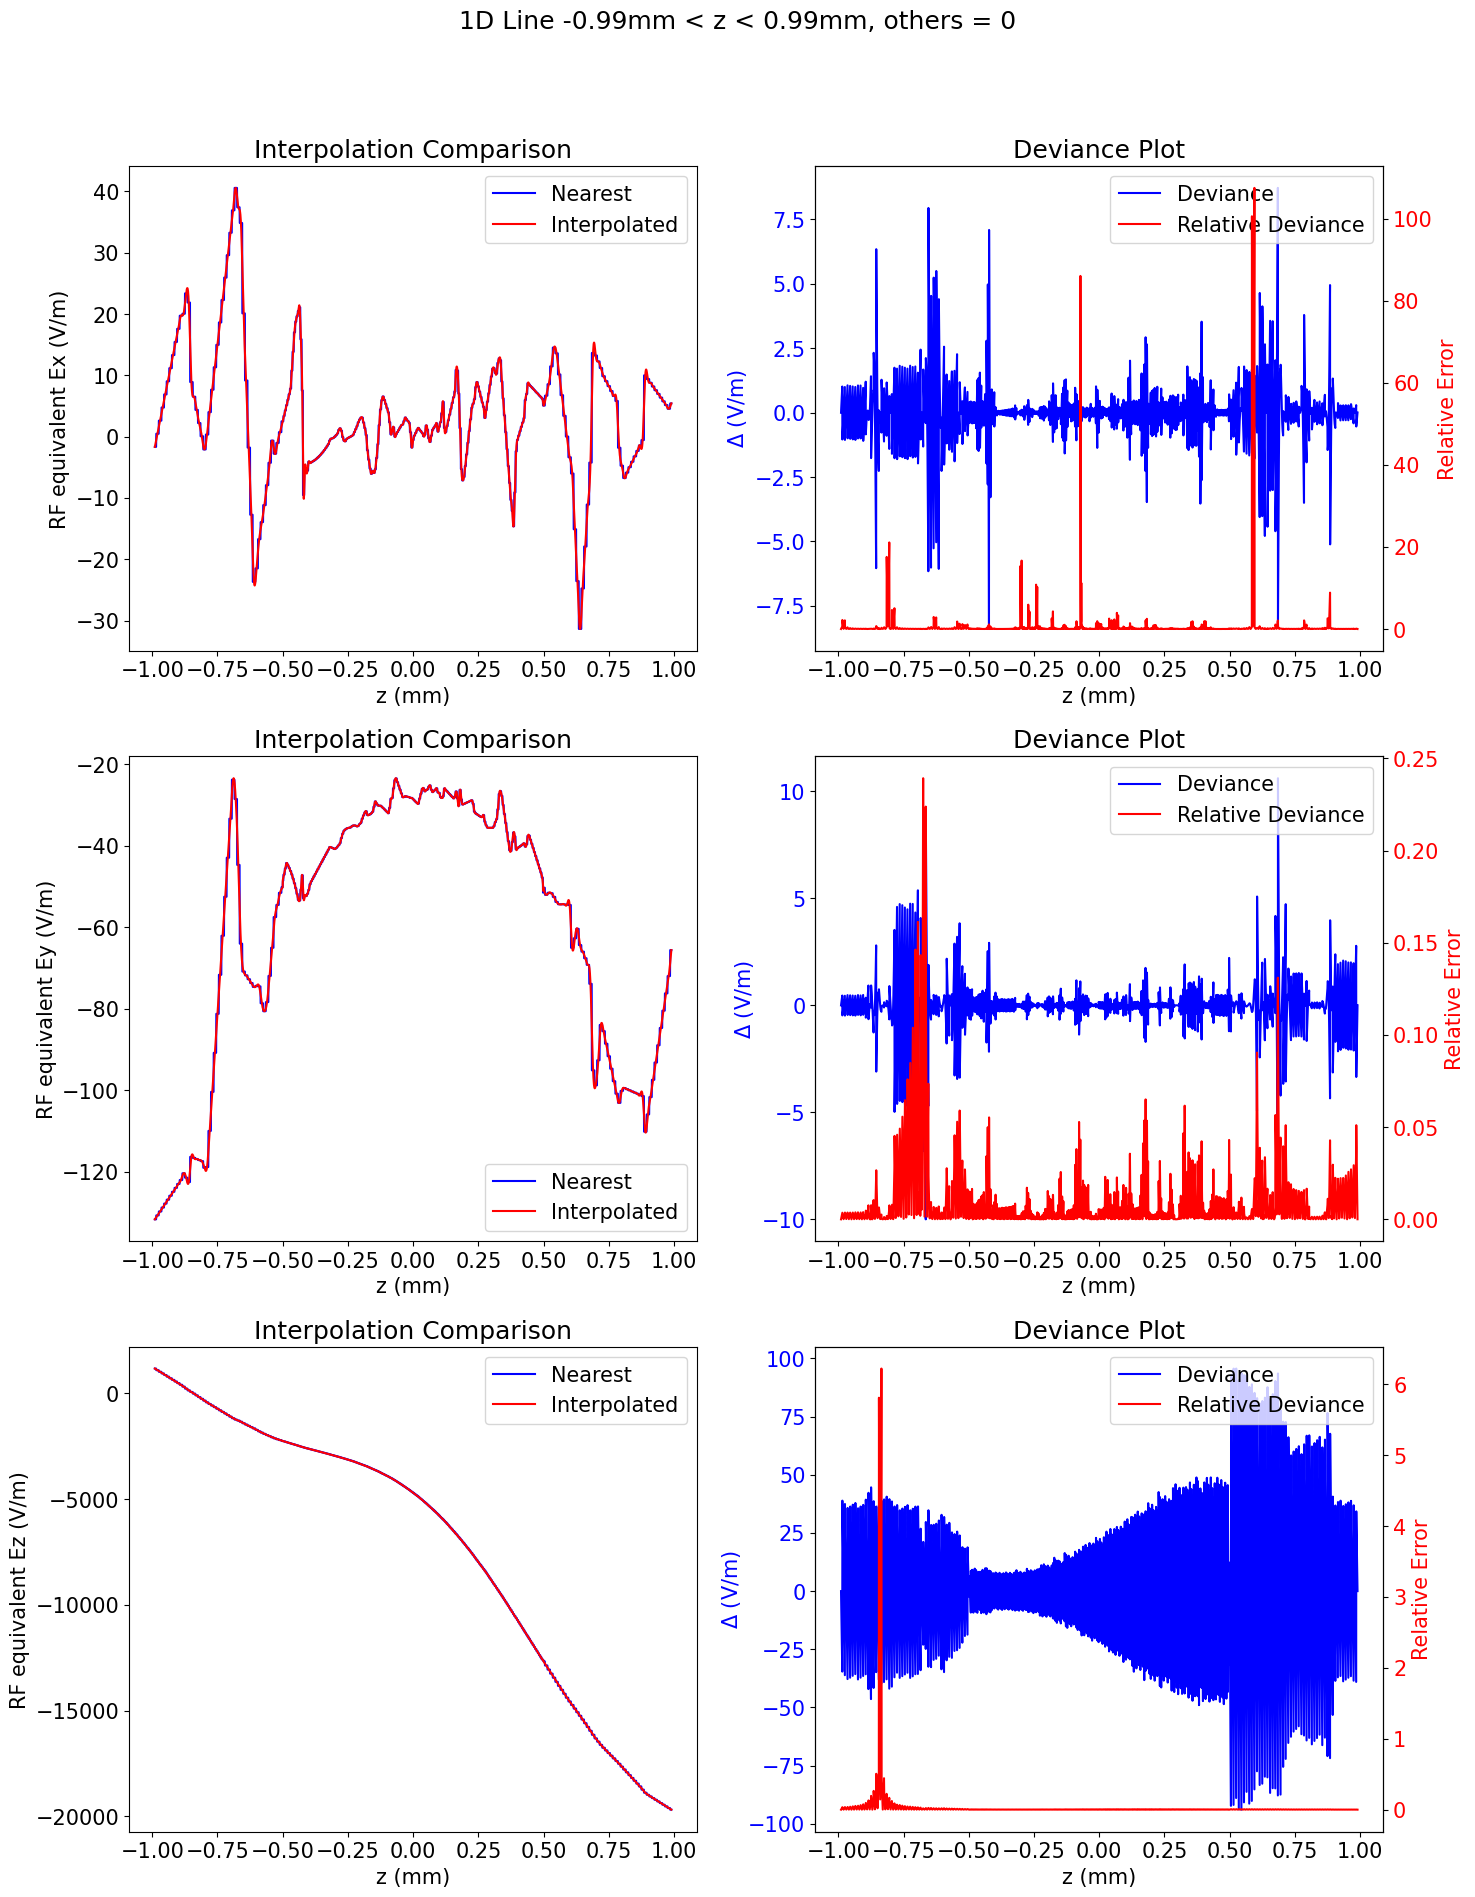

In [113]:
sample_and_plot_1D('z', (-0.99e-3, 0.99e-3))

Computation time: 3.1113 seconds


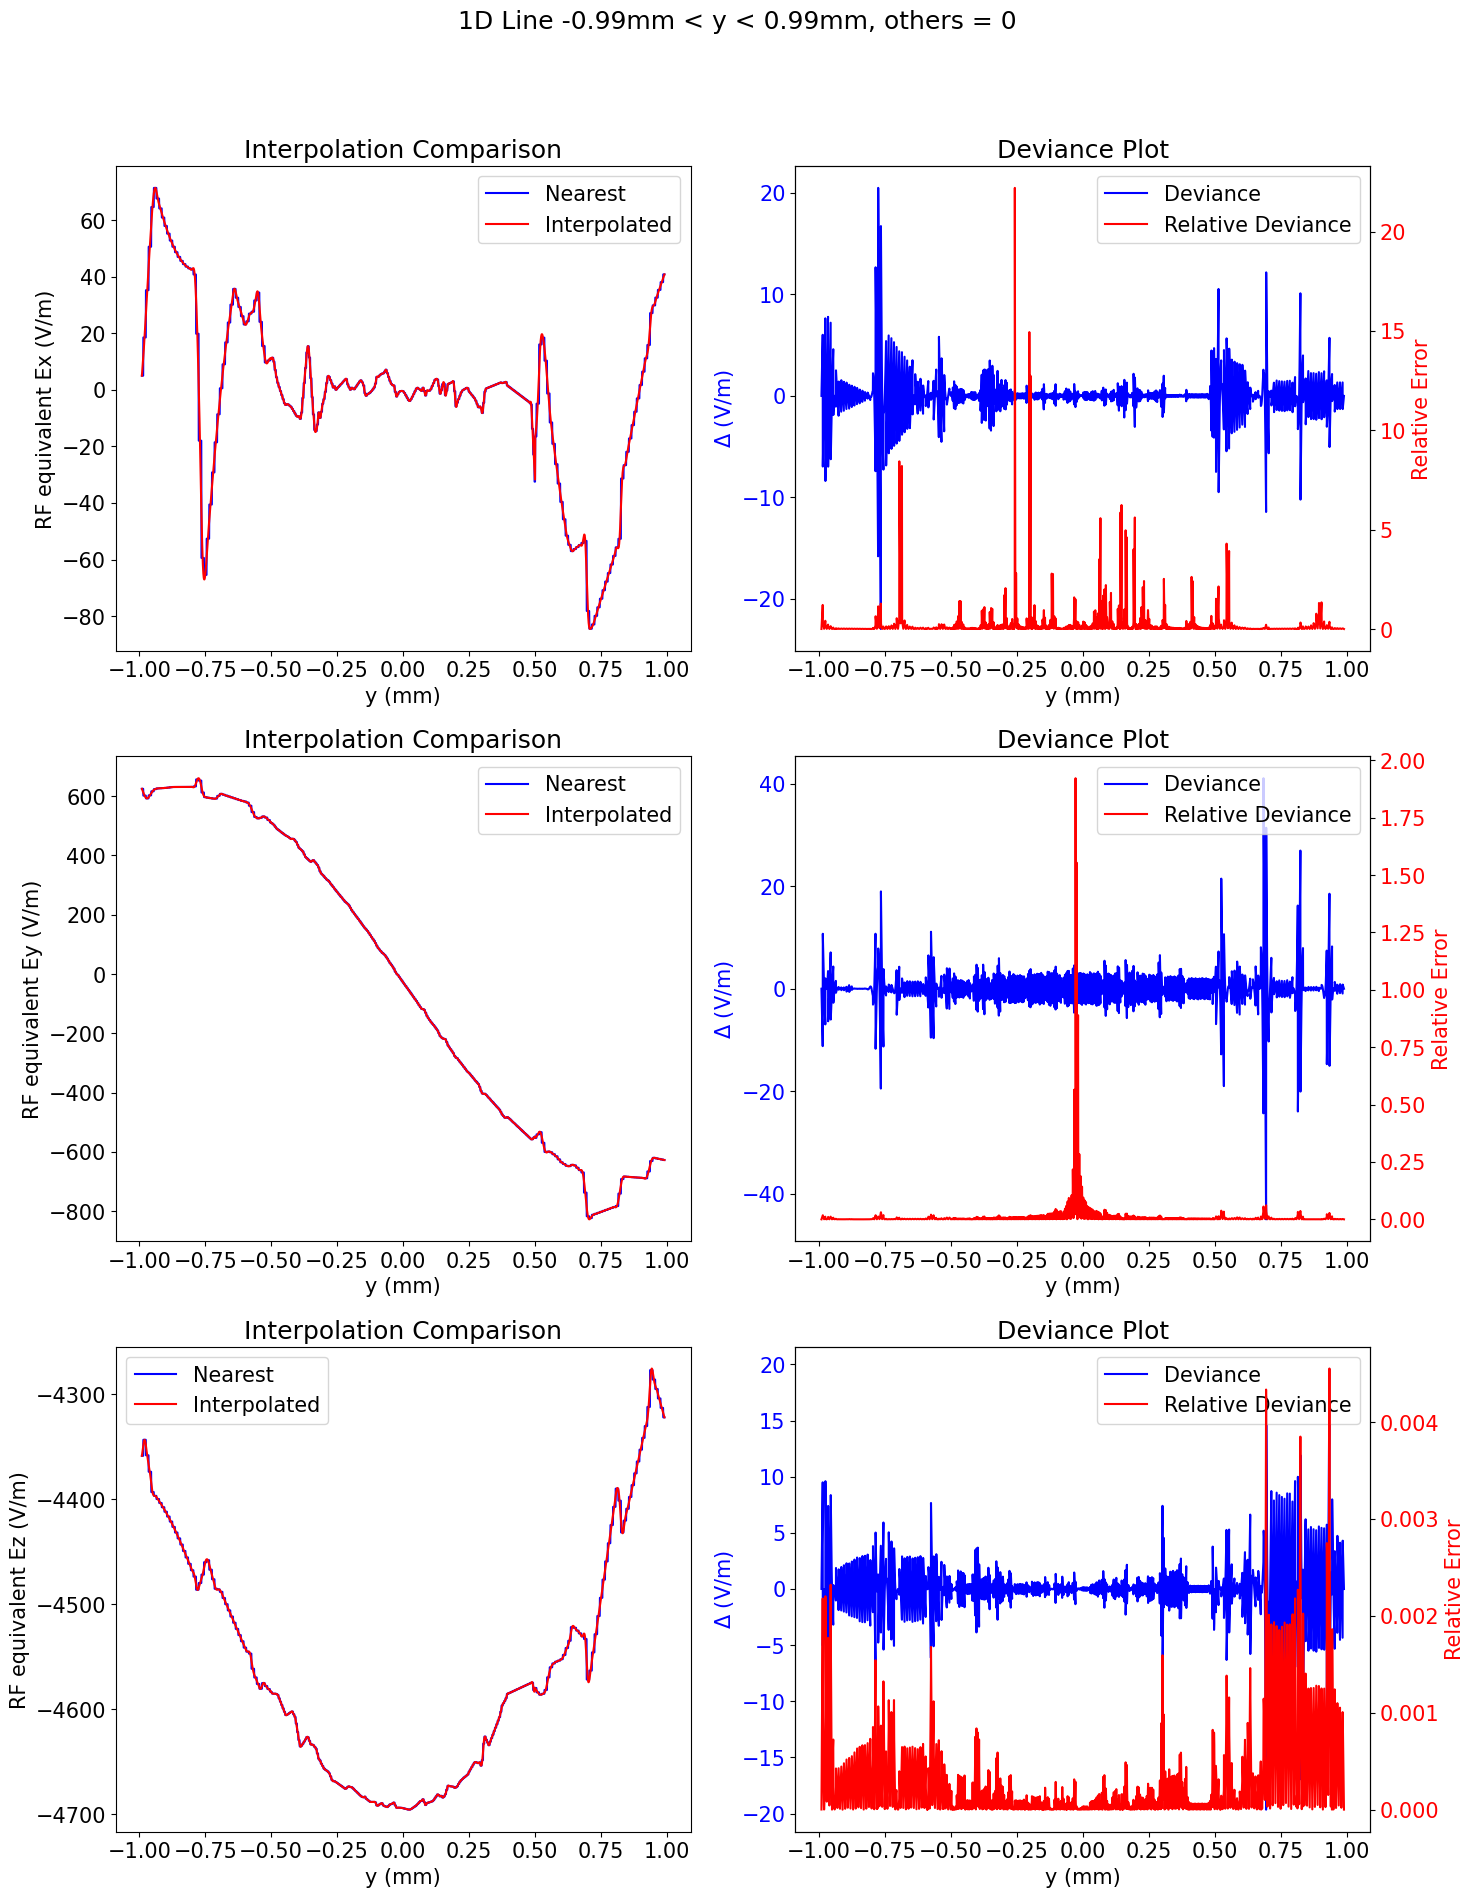

In [115]:
sample_and_plot_1D('y', (-0.99e-3, 0.99e-3))

C:\Users\lluoz\AppData\Local\Temp\ipykernel_18032\1429042131.py:38: RuntimeWarning: divide by zero encountered in divide
  relative_errs[i] = np.abs(errs[i]) / np.abs(nearest_values[i])


Computation time: 2.2509 seconds


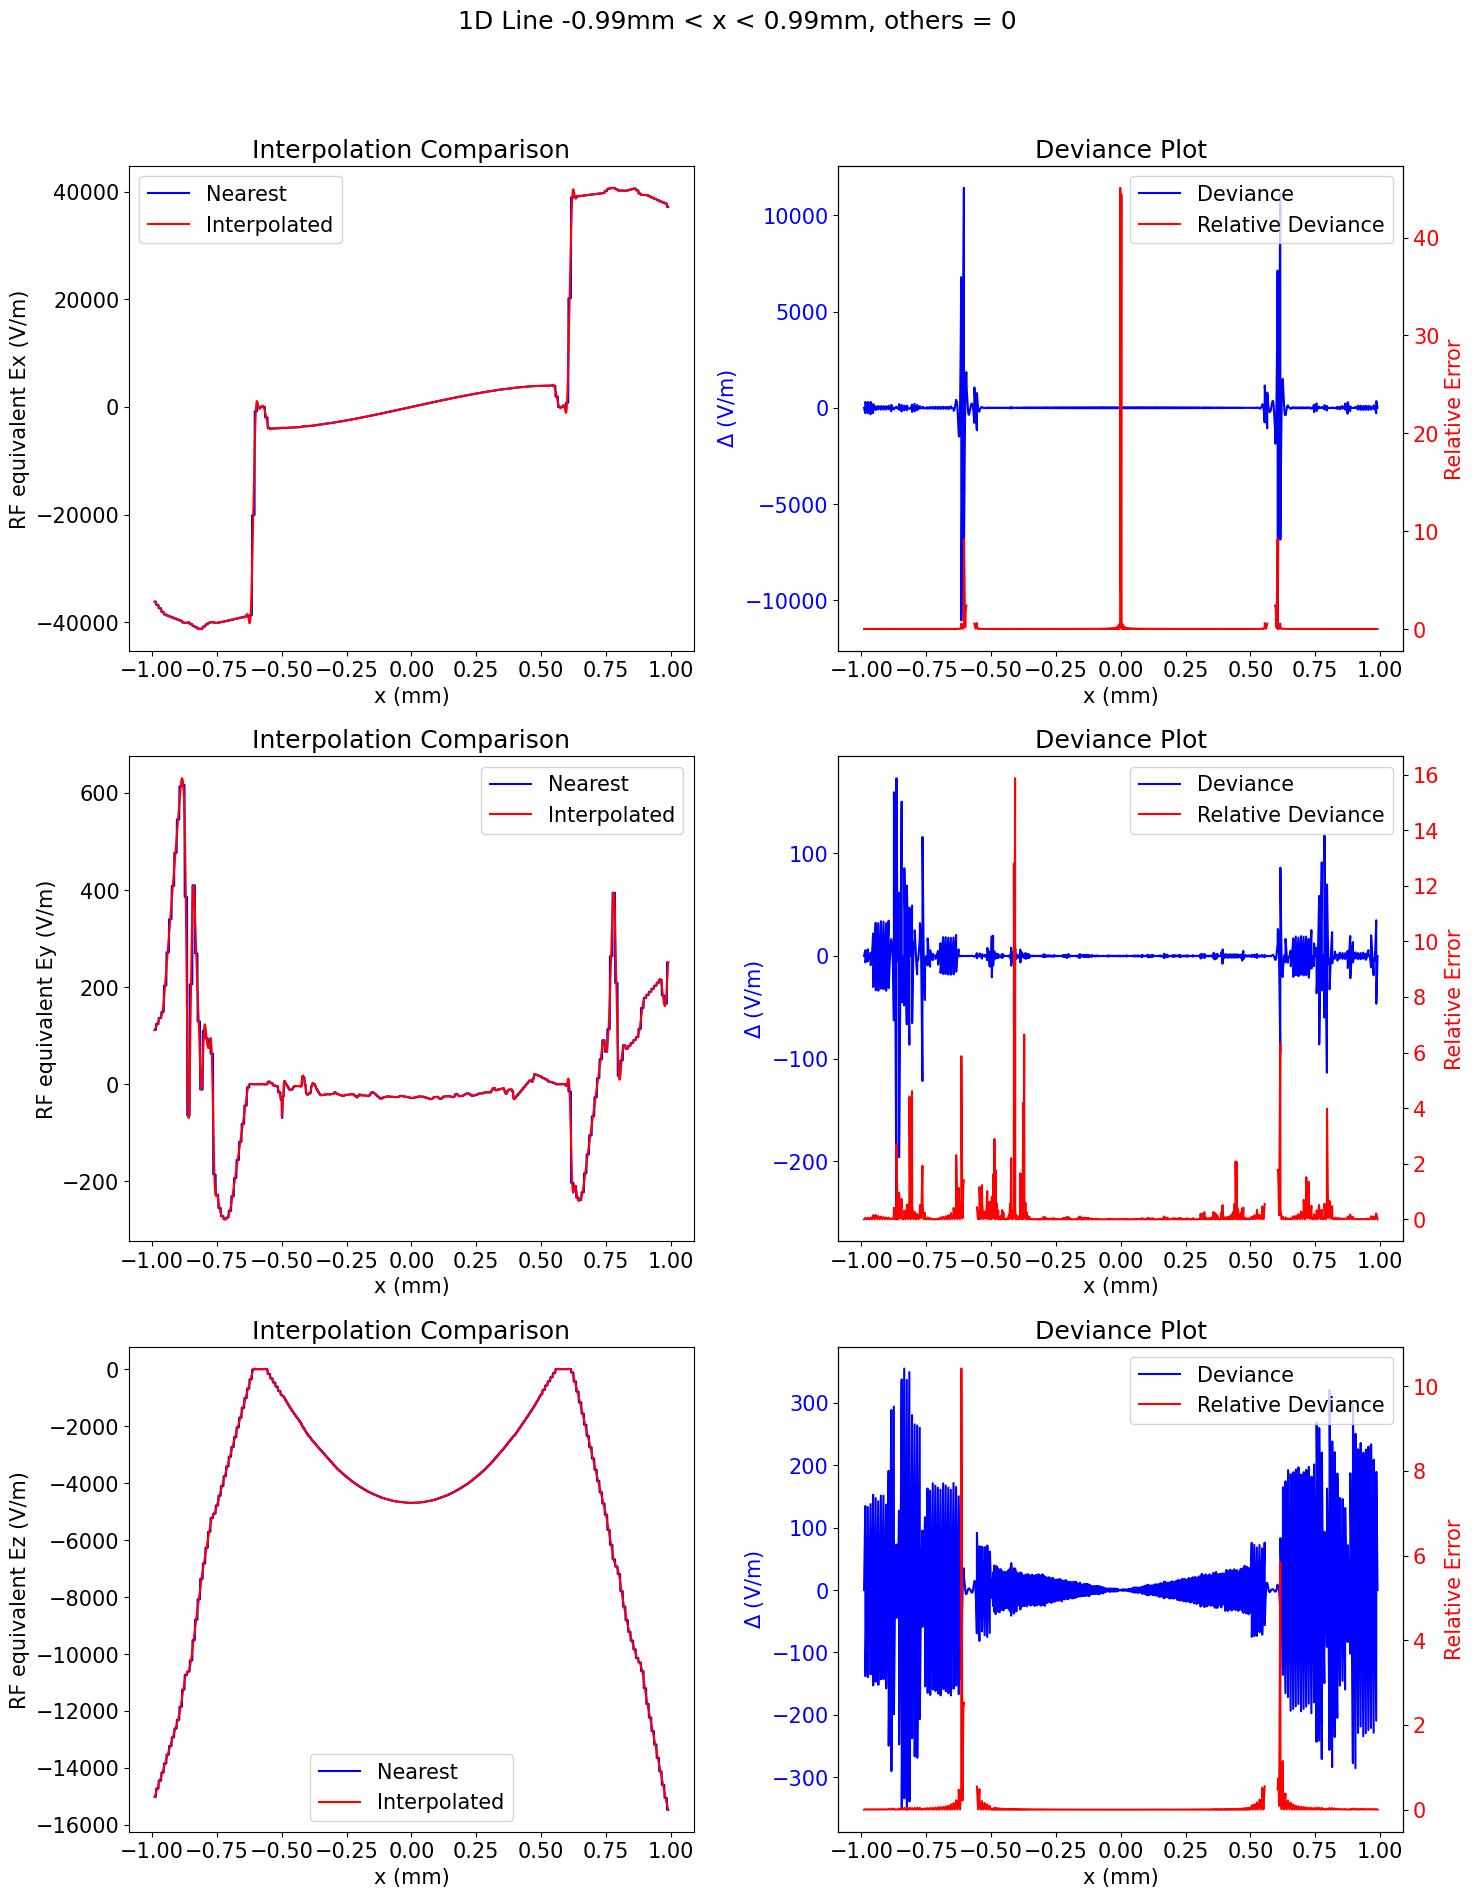

In [117]:
sample_and_plot_1D('x', (-0.99e-3, 0.99e-3))